# Measuring Market Bias

## Utility Functions

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import tensorflow as tf
import sys
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout
import os
import json
import gzip
from urllib.request import urlopen
from matplotlib import rc
from scipy.stats import chi2_contingency, ttest_ind, ttest_rel, f_oneway
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols
rc('pdf', fonttype=42)

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [ ]:
def contingency_table(df_review, columns=[]):
    tab = pd.crosstab(df_review['model_attr'], df_review['user_attr'], margins=True)
    if len(columns)>0:
        tab = tab[columns]
    print('contingency table')
    display(tab)
    tab = df_review.groupby(['model_attr', 'user_attr'])['rating'].size().unstack()
    if len(columns)>1:
        tab = tab[columns[:-1]]
    g, p, dof, expected = chi2_contingency(tab.values)
    print('chi2', g.round(3), 'p-value', p.round(3))
    print('')
    print('real market size - expected market size')
    display((tab-expected).round(2))

In [ ]:
def two_way_anova(df_review, metric):
    test3 = sm.stats.anova_lm(ols(metric+' ~ model_attr*user_attr', data=df_review).fit()).values[:3,-2:]
    df = pd.DataFrame(test3, columns=['F-stat', 'p-value'], index=['product', 'user', 'product:user'])
    display(df.round(3))
    return df

In [ ]:
def plot_avg_by_segment(df_review, metric, figsize, index=[], dataset='', dump=True):
    fig = plt.figure(figsize=figsize)
    group_rating = df_review.groupby(['user_attr', 'model_attr'])[metric].mean().unstack()
    group_std = 1.96*df_review.groupby(['user_attr', 'model_attr'])[metric].sem().unstack()
    if len(index)>0:
        group_rating = group_rating.loc[index]
    group_rating.index = group_rating.index.rename('user identity')
    group_rating.columns = group_rating.columns.rename('product image')
    text = []
    for ri in range(group_rating.shape[0]):
        row = []
        for ci in range(group_rating.shape[1]):
            row.append(str(group_rating.values[ri, ci].round(2))+'\n('+r'$\pm$'+str(group_std.values[ri, ci].round(2))+')')
        text.append(row)
    text = np.array(text)
    
    sns.heatmap(group_rating, annot=text, fmt='s', cmap="YlGnBu", annot_kws={"size": 13},
                cbar=False)
    if dump:
        fig.savefig('./plot/'+dataset+'_'+metric+'_heatmap.pdf', bbox_inches='tight')

## Exploratory Data Analysis

In [ ]:
df_review = pd.read_csv("df_electronics.csv")
df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])
df_review

,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split
0,0,0,5.0,1999-06-13,Female,Portable Audio & Video,NaN,1999,NaN,0
1,0,1,5.0,1999-06-14,Female,Portable Audio & Video,NaN,1999,NaN,0
2,0,2,3.0,1999-06-17,Female,Portable Audio & Video,NaN,1999,NaN,0
3,0,3,1.0,1999-07-01,Female,Portable Audio & Video,NaN,1999,NaN,0
4,0,4,2.0,1999-07-06,Female,Portable Audio & Video,NaN,1999,NaN,0
...,...,...,...,...,...,...,...,...,...,...
1292949,9478,1157628,1.0,2018-09-26,Female,Headphones,Etre Jeune,2017,NaN,0
1292950,9435,1157629,5.0,2018-09-26,Female,Computers & Accessories,NaN,2017,NaN,0
1292951,9305,1157630,3.0,2018-09-26,Female,Computers & Accessories,NaN,2016,NaN,0
1292952,9303,1157631,5.0,2018-09-29,Male,Headphones,NaN,2018,NaN,0


### Product Selection vs Marketing Bias

#### Chi2 test of contingency table

In [ ]:
contingency_table(df_review)

contingency table


user_attr,Female,Male,All
model_attr,,,
Female,34259,31587,65846
Female&Male,26478,24930,51408
Male,25963,30907,56870
All,86700,87424,174124


chi2 581.849 p-value 0.0

real market size - expected market size


user_attr,Female,Male
model_attr,,
Female,1472.89,-1472.89
Female&Male,880.88,-880.88
Male,-2353.77,2353.77


### Consumer Satisfaction vs Marketing Bias

#### Two-way ANOVA

,F-stat,p-value
product,62.581,0.000
user,3.508,0.061
product:user,0.907,0.404


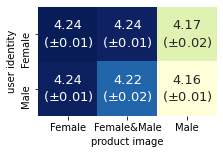

In [ ]:
_ = two_way_anova(df_review, 'rating')
plot_avg_by_segment(df_review, 'rating', (3.2,2), [], 'electronics', dump=False)

## Recommendation Model